# EDA

In [2]:
# Usa raw-strings (r"...") o dobles backslashes en Windows.
PROJECT_DIR = r"C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2\jarvis-calling-hiring-contest"
DATA_PATH   = rf"{PROJECT_DIR}\Resume\Resume.csv"   # ajusta si tu archivo está en otra carpeta

import os, glob

if not os.path.exists(DATA_PATH):
    print("No encontré el archivo en:", DATA_PATH)
    print("Buscando candidatos .csv/.tsv/.json debajo de", PROJECT_DIR, "...")
    candidates = []
    for ext in ("*.csv","*.tsv","*.tab","*.json"):
        candidates += glob.glob(rf"{PROJECT_DIR}\**\{ext}", recursive=True)
    for i, c in enumerate(candidates[:25], 1):
        print(f"{i:02d}. {c}")
    if not candidates:
        raise FileNotFoundError("No")
else:
    print(DATA_PATH)


C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2\jarvis-calling-hiring-contest\Resume\Resume.csv


Definimos columnas clave (TEXT_COL, LABEL_COL), idioma para stopwords (LANG), tamaño máximo del vocabulario TF/IDF, y rutas de salida para figuras y CSV. Crea carpetas si no existen e importa librerías 

In [ ]:

TEXT_COL  = "Resume_str"  
LABEL_COL = "Category"    
LANG = "auto"              # "auto" | "es" | "en" | "none" (stopwords)
MAX_FEATURES = 100_000
SAVE_FIGS = True           # True para guardar PNG
FIG_DIR = rf"{PROJECT_DIR}\figs"
OUT_DIR = rf"{PROJECT_DIR}\outputs"

import os, re, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

from IPython.display import display


Este bloque prepara el texto para el EDA: define stopwords en ES/EN, normaliza (minúsculas+NFKC) y tokeniza eliminando puntuación, y elige automáticamente la lista de stopwords a partir de una muestra del corpus. Así se reducen palabras vacías y ruido en conteos y n-gramas.

In [5]:
SPANISH_STOP = {
    "de","la","que","el","en","y","a","los","del","se","las","por","un","para","con","no","una","su","al","lo",
    "como","más","pero","sus","le","ya","o","este","sí","porque","esta","entre","cuando","muy","sin","sobre",
    "también","me","hasta","hay","donde","quien","desde","todo","nos","durante","todos","uno","les","ni","contra",
    "otros","ese","eso","ante","ellos","e","esto","mí","antes","algunos","qué","unos","yo","otro","otras","otra",
    "él","tanto","esa","estos","mucho","quienes","nada","muchos","cual","poco","ella","estar","estas","algunas",
    "algo","nosotros","mi","mis","tú","te","ti","tu","tus","ellas","nosotras","vosotros","vosotras","oS","mío",
    "mía","míos","mías","tuyo","tuya","tuyos","tuyas","suyo","suya","suyos","suyas","nuestro","nuestra",
    "nuestros","nuestras","vuestro","vuestra","vuestros","vuestras","esos","esas"
}
ENGLISH_STOP = {
    "the","a","an","and","or","but","if","while","of","to","in","on","for","by","with","about","against","between",
    "into","through","during","before","after","above","below","from","up","down","out","over","under","again",
    "further","then","once","here","there","when","where","why","how","all","any","both","each","few","more",
    "most","other","some","such","no","nor","not","only","own","same","so","than","too","very","can","will","just",
    "don","should","now","is","are","was","were","be","been","being","do","does","did","having","have","has","had"
}

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = unicodedata.normalize("NFKC", s)
    return s

def simple_tokenize(s: str):
    s = normalize_text(s)
    s = re.sub(r"[^\w\s]", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+", " ", s).strip()
    return s.split()

def detect_language_stopwords(texts, lang: str = "auto"):
    if lang == "es": return SPANISH_STOP
    if lang == "en": return ENGLISH_STOP
    if lang == "none": return None
    sample = texts[: min(500, len(texts))]
    tokens = [t for s in sample for t in simple_tokenize(s)]
    es_hits = sum(1 for t in tokens if t in SPANISH_STOP)
    en_hits = sum(1 for t in tokens if t in ENGLISH_STOP)
    if es_hits >= en_hits and es_hits > 0: return SPANISH_STOP
    if en_hits > 0: return ENGLISH_STOP
    return None


Este bloque reúne utilidades para cargar y auditar el corpus de texto. 

read_any abre archivos CSV/TSV/JSON sin fricción; infer_columns identifica automáticamente qué columna contiene el texto y cuál la etiqueta si no las indicas. 

Con dataset_health se obtiene un resumen sanitario (tamaño, nulos en texto/etiqueta, duplicados y número de clases) y class_distribution calcula la distribución por clase con porcentajes, acumulado e índice de desbalance. 

Para caracterizar el tamaño de los documentos, add_length_columns añade a cada fila el número de caracteres, palabras y oraciones, y length_stats devuelve estadísticas globales y por clase de esas longitudes. 

In [6]:
def read_any(path, delim=None):
    p = path.lower()
    if p.endswith(".csv"):
        return pd.read_csv(path, sep=delim if delim else ",")
    if p.endswith(".tsv") or p.endswith(".tab"):
        return pd.read_csv(path, sep=delim if delim else "\t")
    if p.endswith(".json"):
        try:
            return pd.read_json(path, lines=True)
        except ValueError:
            return pd.read_json(path)
    return pd.read_csv(path, sep=delim if delim else ",")

def infer_columns(df, text_col=None, label_col=None):
    if text_col in df.columns:
        tc = text_col
    else:
        cand_t = ["text","sentence","content","review","message","body","title","description","comment","Resume_str"]
        tc = next((c for c in cand_t if c in df.columns), None)
    if label_col in df.columns:
        lc = label_col
    else:
        cand_l = ["label","target","class","category","y","sentiment","Category"]
        lc = next((c for c in cand_l if c in df.columns), None)
    if tc is None:
        raise ValueError(f"No se encontró columna de texto. Columnas: {list(df.columns)}")
    if lc is None:
        raise ValueError(f"No se encontró columna de etiqueta. Columnas: {list(df.columns)}")
    return tc, lc

def dataset_health(df, text_col, label_col):
    info = {
        "n_rows": len(df),
        "n_cols": len(df.columns),
        "n_missing_text": int(df[text_col].isna().sum()),
        "n_missing_label": int(df[label_col].isna().sum()),
        "n_duplicates": int(df.duplicated(subset=[text_col, label_col]).sum()),
        "n_classes": int(df[label_col].nunique()),
    }
    return pd.DataFrame([info])

def class_distribution(df, label_col):
    counts = df[label_col].value_counts(dropna=False).rename("count")
    perc = (counts / counts.sum() * 100.0).rename("percent")
    cd = pd.concat([counts, perc], axis=1).reset_index().rename(columns={"index":label_col})
    cd["cumulative_percent"] = cd["percent"].cumsum()
    maj = counts.max()
    minc = counts.min()
    cd.attrs["imbalance_ratio"] = float(maj / max(minc, 1))
    return cd

def add_length_columns(df, text_col):
    texts = df[text_col].astype(str).fillna("")
    df["_num_chars"] = texts.str.len()
    df["_num_words"] = texts.apply(lambda s: len(simple_tokenize(s)))
    df["_num_sents"] = texts.str.count(r"[\.!?]+") + 1
    return df

def length_stats(df, label_col):
    agg = df[["_num_chars","_num_words","_num_sents"]].describe().T
    agg["metric"] = agg.index
    agg.reset_index(drop=True, inplace=True)
    per_class = df.groupby(label_col)[["_num_chars","_num_words","_num_sents"]].agg(["mean","median","min","max"]).copy()
    per_class.columns = ["_".join(c) for c in per_class.columns]
    per_class.reset_index(inplace=True)
    return agg, per_class


Este bloque reúne utilidades de visualización y extracción de términos para el EDA. 

_maybe_save centraliza el guardado de figuras (PNG) cuando SAVE_FIGS=True. 

plot_class_distribution y plot_hist dibujan, respectivamente, la distribución de clases y los histogramas de métricas (p. ej., longitudes), útiles para detectar desbalance y colas largas. 

top_ngrams calcula los n-gramas más frecuentes con CountVectorizer (respeta stopwords, ngram_range y MAX_FEATURES) y plot_top_terms los muestra en barras horizontales. 

Para señal verdaderamente discriminativa, chi2_top_terms_per_class aplica una prueba χ² por clase y devuelve los términos con mayor poder separador. Por último, maybe_wordcloud genera una nube de palabras como recurso visual rápido; todas las figuras se guardan automáticamente en FIG_DIR.

In [7]:
def _maybe_save(fig_name):
    if SAVE_FIGS:
        path = os.path.join(FIG_DIR, fig_name)
        plt.tight_layout()
        plt.savefig(path, dpi=140, bbox_inches="tight")

def plot_class_distribution(df, label_col):
    plt.figure()
    counts = df[label_col].value_counts()
    counts.plot(kind="bar")
    plt.title("Distribución de clases")
    plt.xlabel("Clase")
    plt.ylabel("Frecuencia")
    _maybe_save("class_distribution.png")
    plt.show()

def plot_hist(df, col, title, bins=50):
    plt.figure()
    vals = df[col].astype(float).values
    plt.hist(vals, bins=bins)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    _maybe_save(f"hist_{col}.png")
    plt.show()

def top_ngrams(texts, stopwords=None, n=30, ngram_range=(1,1)):
    vec = CountVectorizer(stop_words=list(stopwords) if stopwords else None,
                          ngram_range=ngram_range,
                          max_features=MAX_FEATURES)
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    order = np.argsort(freqs)[::-1][:n]
    return pd.DataFrame({"term": terms[order], "freq": freqs[order]})

def plot_top_terms(df_terms, title, fig_name):
    plt.figure()
    y = np.arange(len(df_terms))
    plt.barh(y, df_terms["freq"].values)
    plt.yticks(y, df_terms["term"].values)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Frecuencia")
    _maybe_save(fig_name)
    plt.show()

def chi2_top_terms_per_class(texts, labels, stopwords=None, n=15, ngram_range=(1,1)):
    vec = CountVectorizer(stop_words=list(stopwords) if stopwords else None,
                          ngram_range=ngram_range,
                          max_features=MAX_FEATURES)
    X = vec.fit_transform(texts)
    terms = np.array(vec.get_feature_names_out())
    y = pd.Series(labels).astype("category").cat.codes.values
    cat = pd.Series(labels).astype("category").cat.categories
    results = []
    for cls_idx, cls_name in enumerate(cat):
        y_bin = (y == cls_idx).astype(int)
        chi2_scores, _ = chi2(X, y_bin)
        order = np.argsort(chi2_scores)[::-1][:n]
        for t, s in zip(terms[order], chi2_scores[order]):
            results.append({"class": str(cls_name), "term": t, "chi2": float(s)})
    return pd.DataFrame(results)

def maybe_wordcloud(texts, stopwords):
    try:
        from wordcloud import WordCloud
    except Exception:
        print("wordcloud no está instalado; omitiendo nube de palabras.")
        return None
    wc = WordCloud(width=1200, height=800, background_color="white",
                   stopwords=stopwords if stopwords else None)
    txt = " ".join([normalize_text(t) for t in texts])
    img = wc.generate(txt)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    _maybe_save("wordcloud.png")
    plt.show()
    return True


Shape: (2484, 4)
Columnas -> texto: 'Resume_str' | etiqueta: 'Category'


,n_rows,n_cols,n_missing_text,n_missing_label,n_duplicates,n_classes
0,2484,4,0,0,2,24


Imbalance ratio (mayor/menor): 5.454545454545454


,Category,count,percent,cumulative_percent
0,INFORMATION-TECHNOLOGY,120,4.830918,4.830918
1,BUSINESS-DEVELOPMENT,120,4.830918,9.661836
2,FINANCE,118,4.750403,14.412238
3,ADVOCATE,118,4.750403,19.162641
4,ACCOUNTANT,118,4.750403,23.913043
5,ENGINEERING,118,4.750403,28.663446
6,CHEF,118,4.750403,33.413849
7,AVIATION,117,4.710145,38.123994
8,FITNESS,117,4.710145,42.834138
9,SALES,116,4.669887,47.504026


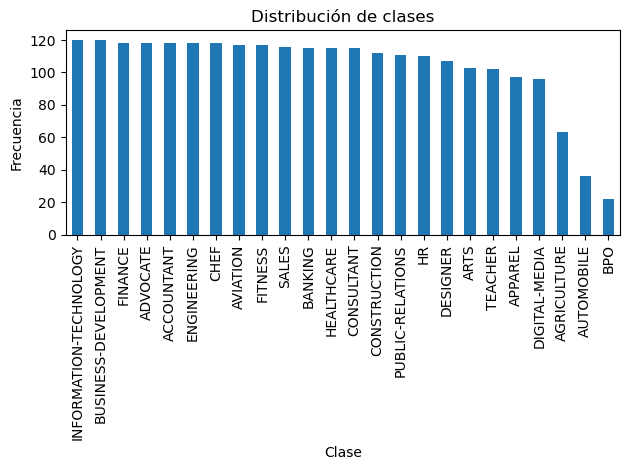

In [8]:
df = read_any(DATA_PATH)
print("Shape:", df.shape)
TEXT_COL, LABEL_COL = infer_columns(df, TEXT_COL, LABEL_COL)
print(f"Columnas -> texto: '{TEXT_COL}' | etiqueta: '{LABEL_COL}'")

health = dataset_health(df, TEXT_COL, LABEL_COL)
display(health)

cd = class_distribution(df, LABEL_COL)
imbalance_ratio = cd.attrs.get("imbalance_ratio", None)
print("Imbalance ratio (mayor/menor):", imbalance_ratio)
display(cd)
plot_class_distribution(df, LABEL_COL)

# Guarda tablas básicas
health.to_csv(rf"{OUT_DIR}\dataset_health.csv", index=False)
cd.to_csv(rf"{OUT_DIR}\class_distribution.csv", index=False)


La gráfica muestra que tus categorías no están equilibradas: hay varias con muchos ejemplos (como IT, Business Development, Finance) y otras con muy pocos (BPO, Automobile, Agriculture, etc.).

Este bloque cuantifica la longitud de los documentos: primero añade a cada fila el número de palabras, caracteres y oraciones; luego calcula estadísticas globales y por clase (media, mediana, mínimos/máximos) y dibuja histogramas de esas tres métricas. 

Esto permite detectar colas largas, outliers y diferencias de longitud entre clases para decidir, por ejemplo, el sequence_length de los modelos o si conviene recortar

Estadísticas globales de longitudes:


,count,mean,std,min,25%,50%,75%,max,metric
0,2484.0,6295.308776,2769.251458,21.0,5160.00,5886.5,7227.25,38842.0,_num_chars
1,2484.0,817.024557,376.781755,0.0,654.75,761.0,940.00,5175.0,_num_words
2,2484.0,40.397343,26.227734,1.0,23.75,38.0,51.00,408.0,_num_sents


Estadísticas por clase:


,Category,_num_chars_mean,_num_chars_median,_num_chars_min,_num_chars_max,_num_words_mean,_num_words_median,_num_words_min,_num_words_max,_num_sents_mean,_num_sents_median,_num_sents_min,_num_sents_max
0,ACCOUNTANT,6293.508475,5871.5,1210,24695,802.144068,748.5,140,3501,39.762712,39.0,2,155
1,ADVOCATE,6575.161017,5843.0,2136,20975,853.915254,750.0,257,3043,42.288136,38.0,4,210
2,AGRICULTURE,6605.285714,5980.0,1560,14612,865.857143,795.0,190,1985,44.888889,39.0,5,241
3,APPAREL,6030.123711,6043.0,1970,13114,781.525773,773.0,240,1752,40.896907,40.0,3,99
4,ARTS,6000.368932,5637.0,1272,12114,780.262136,749.0,166,1550,34.330097,34.0,3,105
5,AUTOMOBILE,6321.250000,5619.0,1749,22032,814.888889,758.5,208,2916,44.138889,38.0,13,153
6,AVIATION,6189.205128,5810.0,1553,14060,800.153846,765.0,197,1883,39.410256,37.0,5,114
7,BANKING,6191.191304,5741.0,1767,15896,808.226087,747.0,221,2141,35.069565,33.0,3,99
8,BPO,7317.681818,6848.5,3317,16223,975.681818,879.0,418,2313,47.409091,44.0,10,102
9,BUSINESS-DEVELOPMENT,6043.975000,5820.0,21,12830,780.333333,755.0,0,1684,39.291667,39.0,1,93


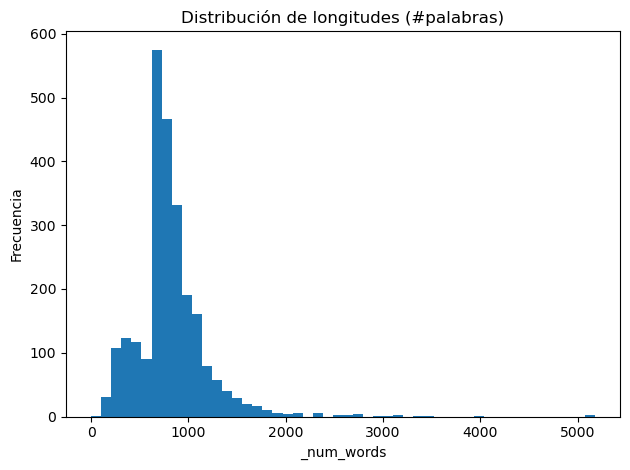

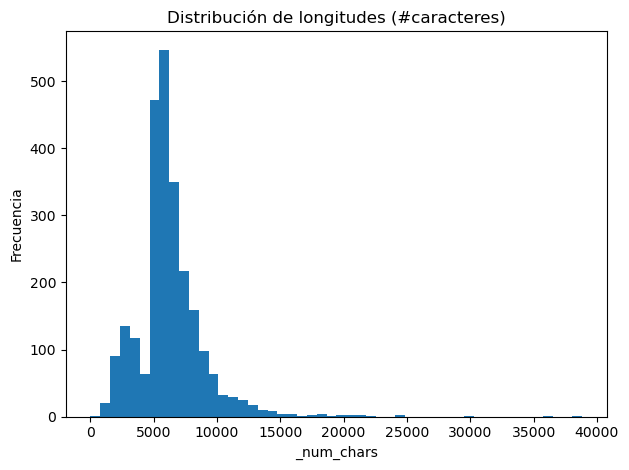

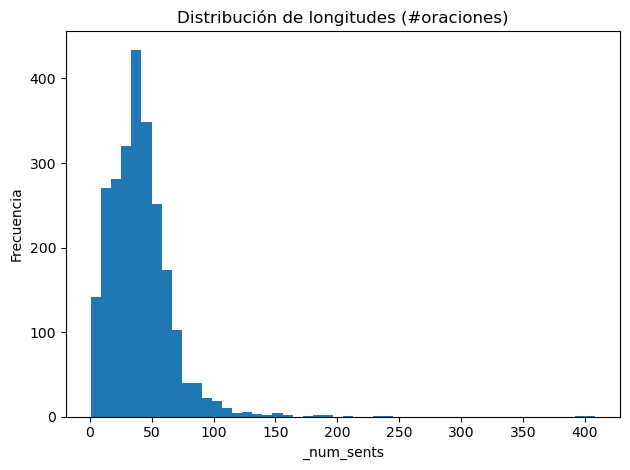

In [9]:
df = add_length_columns(df, TEXT_COL)

agg, per_class = length_stats(df, LABEL_COL)
print("Estadísticas globales de longitudes:")
display(agg)
print("Estadísticas por clase:")
display(per_class)

plot_hist(df, "_num_words", "Distribución de longitudes (#palabras)")
plot_hist(df, "_num_chars", "Distribución de longitudes (#caracteres)")
plot_hist(df, "_num_sents", "Distribución de longitudes (#oraciones)")

agg.to_csv(rf"{OUT_DIR}\length_stats_global.csv", index=False)
per_class.to_csv(rf"{OUT_DIR}\length_stats_per_class.csv", index=False)


La mayoría de los CVs están entre 700 y 1,100 palabras, con una cola larga de pocos casos muy extensos que llegan a miles.

La mayoría de los CVs tienen entre 4 000 y 9 000 caracteres, con unos pocos casos mucho más largos que se van a >20 000–40 000. En pocas palabras casi todo es de tamaño medio y hay unos que son muy grandes.

Igualmente por parte del número de frases (sentences) se puede ver que es común estar entre las 0 y 70 oraciones, sin embargo se puede extender a mucho mas, llegando hasta 400 para algunos casos.



Este bloque detecta automáticamente la lista de stopwords (ES/EN) y la aplica para extraer los términos más frecuentes del corpus: calcula y muestra los top unigrams, bigrams y trigrams con CountVectorizer, los grafica para una lectura rápida y guarda los resultados en CSV.

Stopwords usadas: EN


,term,freq
0,state,16159
1,company,15212
2,city,15077
3,management,12173
4,name,11739
5,as,10627
6,sales,8275
7,customer,7927
8,business,7866
9,skills,7729


,term,freq
0,city state,14107
1,company name,11563
2,name city,9900
3,customer service,3061
4,as well,1529
5,well as,1478
6,project management,1198
7,current company,1177
8,microsoft office,1145
9,university city,1101


,term,freq
0,company name city,9900
1,name city state,9719
2,as well as,1451
3,current company name,1173
4,university city state,1024
5,2014 company name,653
6,college city state,609
7,2015 company name,574
8,2013 company name,559
9,city state usa,534


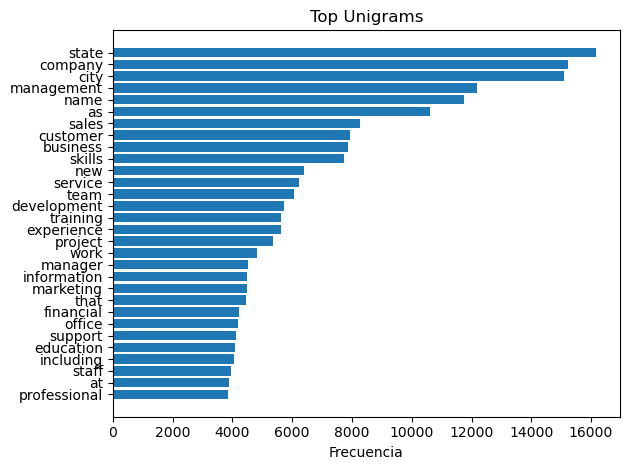

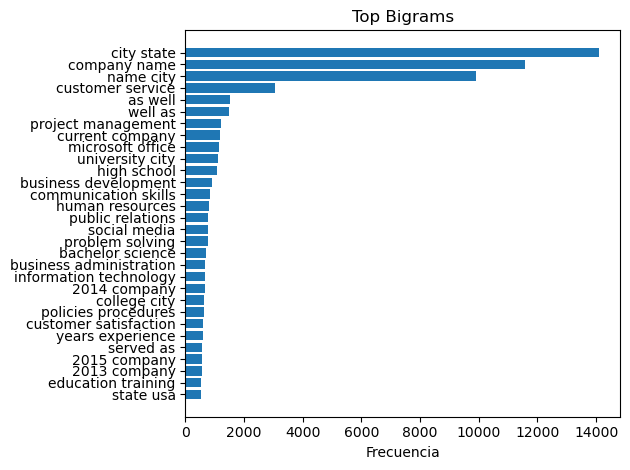

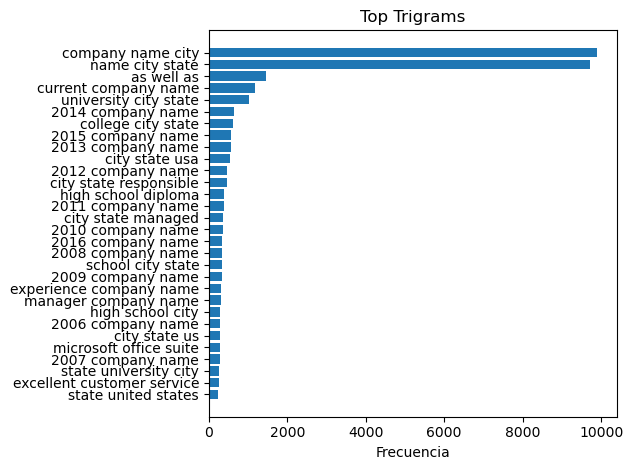

In [10]:
texts = df[TEXT_COL].astype(str).fillna("").tolist()
stops = detect_language_stopwords(texts, LANG)
print("Stopwords usadas:", "ninguna" if stops is None else ("ES" if stops==SPANISH_STOP else "EN"))

top_uni = top_ngrams(texts, stopwords=stops, n=30, ngram_range=(1,1))
top_bi  = top_ngrams(texts, stopwords=stops, n=30, ngram_range=(2,2))
top_tri = top_ngrams(texts, stopwords=stops, n=30, ngram_range=(3,3))

display(top_uni.head(10)); display(top_bi.head(10)); display(top_tri.head(10))

plot_top_terms(top_uni, "Top Unigrams", "top_unigrams.png")
plot_top_terms(top_bi,  "Top Bigrams",  "top_bigrams.png")
plot_top_terms(top_tri, "Top Trigrams", "top_trigrams.png")

top_uni.to_csv(rf"{OUT_DIR}\top_unigrams.csv", index=False)
top_bi.to_csv(rf"{OUT_DIR}\top_bigrams.csv", index=False)
top_tri.to_csv(rf"{OUT_DIR}\top_trigrams.csv", index=False)


Los tres gráficos muestran que el texto está lleno de frases de plantilla de CV: “state/city/company/name”, años (“2014/2015 company”), y expresiones muy generales (“customer service”, “project management”). Eso significa que, aunque hay algunas pistas útiles, la mayoría de los n-gramas más frecuentes no distinguen bien las categorías porque aparecen en casi todos los CVs.

Este bloque identifica términos discriminativos por clase usando una prueba de chi-cuadrado sobre un CountVectorizer con unigrama y las stopwords detectadas. Para cada categoría, convierte el problema en binario (clase vs. resto), calcula el estadístico χ² de cada término y devuelve los 15 con mayor poder separador; así puedes ver qué palabras están más asociadas estadísticamente a cada etiqueta.

In [11]:
chi2_terms = chi2_top_terms_per_class(
    texts=texts,
    labels=df[LABEL_COL].tolist(),
    stopwords=stops,
    n=15,
    ngram_range=(1,1)
)
display(chi2_terms.head(30))
chi2_terms.to_csv(rf"{OUT_DIR}\chi2_top_terms_per_class.csv", index=False)


,class,term,chi2
0,ACCOUNTANT,accounting,9251.293576
1,ACCOUNTANT,accountant,7911.719874
2,ACCOUNTANT,financial,4050.768207
3,ACCOUNTANT,accounts,3518.533196
4,ACCOUNTANT,tax,3185.513882
5,ACCOUNTANT,ledger,3078.620102
6,ACCOUNTANT,entries,2678.728852
7,ACCOUNTANT,reconciliations,2198.122303
8,ACCOUNTANT,statements,2116.145648
9,ACCOUNTANT,journal,1651.692322


In [13]:
print("Archivos generados en:")
print(" - Figuras:", FIG_DIR)
print(" - Tablas:", OUT_DIR)
print("\nSiguiente paso recomendado: hacer el split train/val/test y entrenar baselines (TF-IDF+XGBoost, FastText).")


Archivos generados en:
 - Figuras: C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2\jarvis-calling-hiring-contest\figs
 - Tablas: C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2\jarvis-calling-hiring-contest\outputs

Siguiente paso recomendado: hacer el split train/val/test y entrenar baselines (TF-IDF+XGBoost, FastText).


In [15]:
from wordcloud import WordCloud


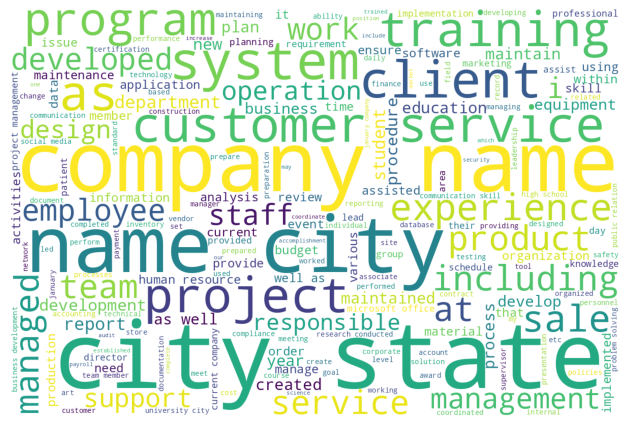

In [ ]:
_ = maybe_wordcloud(texts, stops)


La nube de palabras está dominada por términos de plantilla del CV —“city”, “state”, “company”, “name”, “customer”, “service”, “project”, “system”, “training”… Eso confirma que el corpus tiene mucho texto genérico como company name o city state

<Figure size 640x480 with 0 Axes>

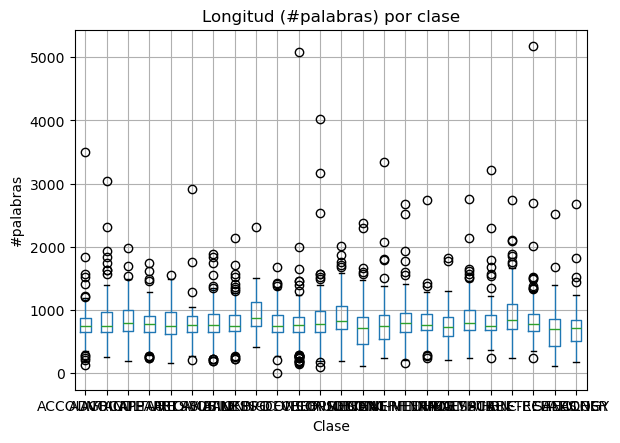

In [ ]:
plt.figure()
df.boxplot(column=["_num_words"], by=LABEL_COL,)
plt.title("Longitud (#palabras) por clase"); plt.suptitle("")
plt.xlabel("Clase"); plt.ylabel("#palabras")
plt.show()